In [21]:
import io
import os, sys
import requests
import PIL
from PIL import Image
import cv2
import numpy as np

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

# target_image_size = 256
target_image_size = 120

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

In [12]:
# This can be changed to a GPU, e.g. 'cuda:0'.
dev = torch.device('cuda:3')

# For faster load times, download these files locally and use the local paths instead.
enc = load_model("https://cdn.openai.com/dall-e/encoder.pkl", dev)
dec = load_model("https://cdn.openai.com/dall-e/decoder.pkl", dev)

In [22]:
# load video
cap = cv2.VideoCapture('/shared/nas/data/m1/wangz3/cs543_project/datasets/KTH/walking/person01_walking_d1_uncomp.avi')

image_sequence_PIL = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = Image.fromarray(frame)
        image_sequence_PIL.append(frame)
    else:
        break
    # display(gray)
    # cv2.imshow('frame',gray)
    
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break
    
cap.release()
cv2.destroyAllWindows()

image sequence length:  555


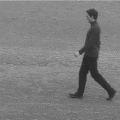

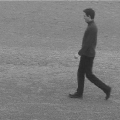

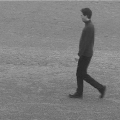

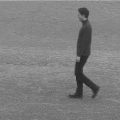

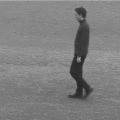

In [52]:
print('image sequence length: ', len(image_sequence_PIL))
frame_idx = 25
x_0 = preprocess(image_sequence_PIL[frame_idx])
x_1 = preprocess(image_sequence_PIL[frame_idx+1])
x_2 = preprocess(image_sequence_PIL[frame_idx+2])
x_3 = preprocess(image_sequence_PIL[frame_idx+3])
x_4 = preprocess(image_sequence_PIL[frame_idx+4])
# display(image_sequence_PIL[10])
# x = preprocess(download_image('https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iKIWgaiJUtss/v2/1000x-1.jpg'))

display_markdown('Original image:')
display(T.ToPILImage(mode='RGB')(x_0[0]))
display(T.ToPILImage(mode='RGB')(x_1[0]))
display(T.ToPILImage(mode='RGB')(x_2[0]))
display(T.ToPILImage(mode='RGB')(x_3[0]))
display(T.ToPILImage(mode='RGB')(x_4[0]))

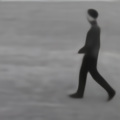

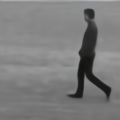

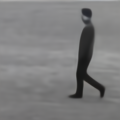

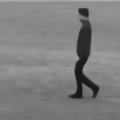

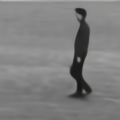

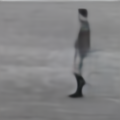

In [55]:
import torch.nn.functional as F

def decode(z_logits):
    z = torch.argmax(z_logits, axis=1)
    z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()
    x_stats = dec(z).float()
    x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
    x_rec = T.ToPILImage(mode='RGB')(x_rec[0])
    # display_markdown('Reconstructed image:')
    display(x_rec)

z_logits_seq = []
z_seq = []

# encoding
for x in [x_0, x_1, x_2, x_3, x_4]:
    x = x.to(dev)
    z_logits = enc(x)
    z_logits_seq.append(z_logits)
    z = torch.argmax(z_logits, axis=1)
    z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()
    z_seq.append(z)
    # play around
    # z = torch.ones(z.size()).to(dev)

# decoding
for z in z_seq:
    x_stats = dec(z).float()
    x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
    x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

    # display_markdown('Reconstructed image:')
    display(x_rec)
print('=======================================')

z_0_1_avg_logit = torch.mean(torch.stack(z_logits_seq[3:5]), dim = 0)

decode(z_0_1_avg_logit)